In [1]:
## Importing Libraries:

import warnings
warnings.filterwarnings('ignore')
import numpy as np 
import pandas as pd 
import seaborn as sns 
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold,StratifiedKFold,train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import roc_auc_score
from lightgbm import LGBMClassifier
import os
import eli5
from eli5.sklearn import PermutationImportance
from catboost import CatBoostClassifier

In [2]:
## Importing Data:

train = pd.read_csv("C:/Users/Aditya/Desktop/HR Analytics/train.csv")
test = pd.read_csv("C:/Users/Aditya/Desktop/HR Analytics/test.csv")
sample = pd.read_csv("C:/Users/Aditya/Desktop/HR Analytics/sample_submission.csv")

In [ ]:
train.head()

In [ ]:
## Checking for Missing Values:

train.isnull().sum()

In [ ]:
duplicate_train = train[train.duplicated()]

In [ ]:
duplicate_train

In [ ]:
train.info()

In [ ]:
sns.distplot(train['age'])

In [ ]:
## Information of objective variables:

object_col = []

for column in train.columns:
    if train[column].dtype == object and len(train[column].unique()) <=30:
        object_col.append (column)
        print (f"{column} : {train[column].unique()}")
        print (train[column].value_counts())
        print ("================")

In [ ]:
train.isnull().sum()

In [ ]:
train['education'].value_counts()

In [3]:
train['education'] = train['education'].fillna("Bachelor's")

In [ ]:
train['previous_year_rating'].value_counts()

In [ ]:
sns.distplot(train['previous_year_rating'])

In [4]:
train['previous_year_rating'] = train['previous_year_rating'].fillna(3.0)

In [ ]:
train.head()

In [ ]:
test.isnull().sum()

In [5]:
## Filling Missing values:

test['education'] = test['education'].fillna("Bachelor's")
test['previous_year_rating'] = test['previous_year_rating'].fillna(3.0)

In [ ]:
test['previous_year_rating'].value_counts()

In [ ]:
sns.barplot(train['is_promoted'],train['is_promoted'].value_counts())

In [ ]:
train['is_promoted'].value_counts()

In [ ]:
train.shape

## Data Processing:

In [ ]:
train=train.drop_duplicates(subset=[ele for ele in list(train.columns) if ele not in ['employee_id']])

In [ ]:
train.shape

In [6]:
combine_set=pd.concat([train,test], ignore_index=True)

In [ ]:
combine_set.shape

In [ ]:
combine_set.head()

In [7]:
le=LabelEncoder()

In [8]:
combine_set['gender']=le.fit_transform(combine_set['gender'])
combine_set['department']=le.fit_transform(combine_set['department'])
#combine_set['recruitment_channel']=le.fit_transform(combine_set['recruitment_channel'])

In [9]:
combine_set['education'].value_counts()

Bachelor's          55690
Master's & above    21429
Below Secondary      1179
Name: education, dtype: int64

In [10]:
combine_set['education']=combine_set['education'].map({'Below Secondary':1,"Bachelor's":2,"Master's & above":3})

In [ ]:
combine_set.tail()

In [11]:
combine_set[['region1','region']] =  combine_set['region'].str.split("_", expand = True)

In [12]:
combine_set.drop(['region1'], axis = 1, inplace = True)

In [ ]:
plt.figure(figsize=(10,10))
sns.heatmap(combine_set.corr(),annot=True,fmt=".2f")

In [13]:
combine_set['previous_year_rating'] = combine_set['previous_year_rating'].astype('int')

In [14]:
combine_set['Total_Score'] = combine_set['no_of_trainings'] * combine_set['avg_training_score']

In [15]:
combine_set['departmentwise_rating_sum']=combine_set.groupby(['department'])['previous_year_rating'].transform('sum')
#combine_set['departmentwise_rating_SD']=combine_set.groupby(['department'])['previous_year_rating'].transform('std')
#combine_set['departmentwise_rating_uni']=combine_set.groupby(['department'])['previous_year_rating'].transform('nunique')


combine_set['recruitment_rating_sum']=combine_set.groupby(['recruitment_channel'])['previous_year_rating'].transform('sum')
#combine_set['recruitment_rating_SD']=combine_set.groupby(['recruitment_channel'])['previous_year_rating'].transform('std')
#combine_set['recruitment_rating_uni']=combine_set.groupby(['recruitment_channel'])['previous_year_rating'].transform('nunique')

In [ ]:
#combine_set['departmentwise_rating_mod']=combine_set.groupby(['department'])['previous_year_rating'].agg(lambda x:x.value_counts().index[0])

In [ ]:
combine_set.head()

In [16]:
combine_set['education_rating_sum']=combine_set.groupby(['education'])['previous_year_rating'].transform('sum')
#combine_set['education_rating_SD']=combine_set.groupby(['education'])['previous_year_rating'].transform('std')
#combine_set['education_rating_uni']=combine_set.groupby(['education'])['previous_year_rating'].transform('nunique')

In [17]:
combine_set['awards_won_rating_sum']=combine_set.groupby(['awards_won?'])['previous_year_rating'].transform('sum')
#combine_set['service_length_rating_sd']=combine_set.groupby(['length_of_service'])['previous_year_rating'].transform('std')
#combine_set['service_length_rating_nuq']=combine_set.groupby(['length_of_service'])['previous_year_rating'].transform('nunique')

In [ ]:
sns.boxplot(combine_set['age'])

In [18]:
combine_set['service_length_rating_sum']=combine_set.groupby(['length_of_service'])['previous_year_rating'].transform('sum')
#combine_set['service_length_rating_sd']=combine_set.groupby(['length_of_service'])['previous_year_rating'].transform('std')
#combine_set['service_length_rating_uni']=combine_set.groupby(['length_of_service'])['previous_year_rating'].transform('nunique')

In [19]:
combine_set['age_service_length_rating_sum']=combine_set.groupby(['length_of_service','age'])['previous_year_rating'].transform('sum')
#combine_set['age_service_length_rating_sd']=combine_set.groupby(['length_of_service','age'])['previous_year_rating'].transform('std')
#combine_set['age_service_length_rating_uni']=combine_set.groupby(['length_of_service','age'])['previous_year_rating'].transform('nunique')

In [20]:
combine_set['region_rating_sum']=combine_set.groupby(['region'])['previous_year_rating'].transform('sum')
#combine_set['region_rating_SD']=combine_set.groupby(['region'])['previous_year_rating'].transform('std')
#combine_set['region_rating_uni']=combine_set.groupby(['region'])['previous_year_rating'].transform('nunique')

In [21]:
combine_set['KPI_rating_sum']=combine_set.groupby(['KPIs_met >80%'])['previous_year_rating'].transform('sum')
#combine_set['KPI_rating_SD']=combine_set.groupby(['KPIs_met >80%'])['previous_year_rating'].transform('std')
#combine_set['KPI_rating_uni']=combine_set.groupby(['KPIs_met >80%'])['previous_year_rating'].transform('nunique')

In [ ]:
pd.set_option('display.max_columns', None)
combine_set.head()

In [ ]:
combine_set.shape

In [ ]:
combine_set['age_service_length_rating_uni'].value_counts()

In [22]:
from sklearn.preprocessing import KBinsDiscretizer

In [23]:
age_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

In [24]:
combine_set['Age_Bins'] =age_discretizer.fit_transform(combine_set['age'].values.reshape(-1,1)).astype(int)

In [25]:
train_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
service_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')

In [26]:
combine_set['train_score_Bins'] =train_discretizer.fit_transform(combine_set['avg_training_score'].values.reshape(-1,1)).astype(int)
combine_set['service_Bins'] =service_discretizer.fit_transform(combine_set['length_of_service'].values.reshape(-1,1)).astype(int)

In [ ]:
combine_set.head()

In [27]:
region_discretizer = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
combine_set['region'] =region_discretizer.fit_transform(combine_set['region'].values.reshape(-1,1)).astype(int)

In [ ]:
combine_set.isnull().sum()

In [28]:
recruite_counts = combine_set['recruitment_channel'].value_counts().to_dict()

In [29]:
combine_set['recruitment_channel'] = combine_set['recruitment_channel'].map(recruite_counts)

In [ ]:
combine_set.head()

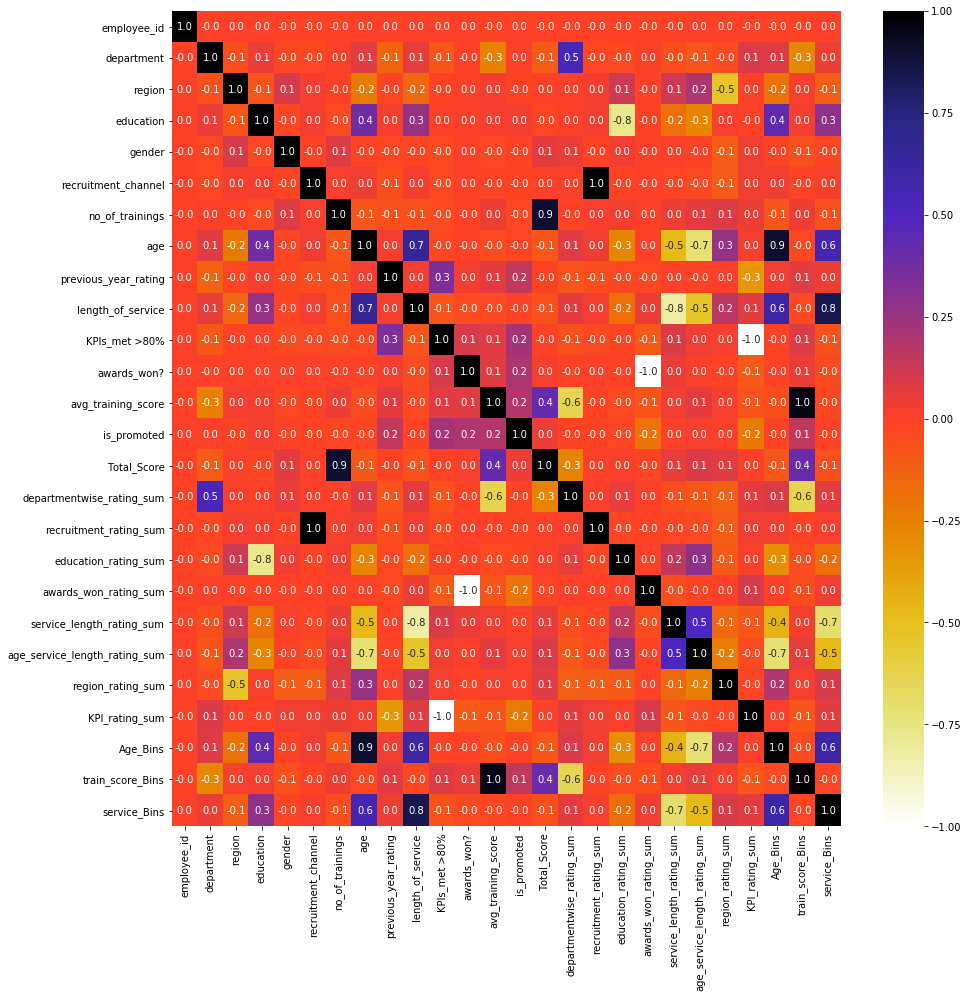

In [30]:
plt.figure(figsize=(15,15))
sns.heatmap(combine_set.corr(),annot=True,fmt=".1f",cmap=plt.cm.CMRmap_r)

In [31]:
# with the following function we can select highly correlated features
# it will remove the first feature that is correlated with anything other feature

def correlation(combine_set, threshold):
    col_corr = set()  # Set of all the names of correlated columns
    corr_matrix = combine_set.corr()
    for i in range(len(corr_matrix.columns)):
        for j in range(i):
            if (corr_matrix.iloc[i, j]) > threshold: # we are interested in absolute coeff value
                colname = corr_matrix.columns[i]  # getting the name of column
                col_corr.add(colname)
    return col_corr

In [32]:
corr_features = correlation(combine_set, 0.7)
len(set(corr_features))

5

In [33]:
corr_features

{'Age_Bins',
 'Total_Score',
 'recruitment_rating_sum',
 'service_Bins',
 'train_score_Bins'}

In [ ]:
combine_set['is_promoted'].value_counts()

In [ ]:
combine_set.head()

In [34]:
train_df=combine_set[combine_set['is_promoted'].isnull()==False]
test_df=combine_set[combine_set['is_promoted'].isnull()==True]

In [35]:
X=train_df.drop(['employee_id','is_promoted','Age_Bins','recruitment_rating_sum',
                'Total_Score','service_Bins','train_score_Bins'],axis=1)
y=train_df['is_promoted']

X_main_test=test_df.drop(['employee_id','is_promoted','Age_Bins','recruitment_rating_sum',
                'Total_Score','service_Bins','train_score_Bins'],axis=1)

In [36]:
#Kfold
kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=123)
pred_score=0
preds=0

In [ ]:
X.info()

## Light GBM:

In [ ]:
import lightgbm as lgb
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
gbm = lgb.LGBMClassifier()

In [ ]:
for i, (train_idx,val_idx) in enumerate(kf.split(X,y)):
    X_train,y_train=X.iloc[train_idx,:],y.iloc[train_idx]
    X_val,y_val=X.iloc[val_idx,:],y.iloc[val_idx]
    
    print('\nFold: {}\n'.format(i+1))
    
    hyper_params = {
    "learning_rate":[0.05,0.1,0.15,0.2,0.25],
    "max_depth":[3,4,5,7,9,10,15,20],
    "min_data_in_leaf":[10,20,25,30],
    "lambda" : [0,0.01, 0.05, 0.1 ,0.2, 0.5, 0.8],   
    #"colsample_bytree":[0.3,0.4,0.5,0.6],
    "num_leaves " : [10,20,30,40,50,100],
    "eval_metric" : ['auc'],
    #"num_leaves":[10,20,30,50,100],
    "boosting" : ['gbdt','goss']
    #"n_estimators" : [100, 500, 900, 1100, 1500]
}
    
    random_search = RandomizedSearchCV(gbm,param_distributions = hyper_params,
                                  n_iter = 50,
                                  n_jobs = -1,cv = 5, verbose = 50)

    random_search.fit(X_train,y_train)
    print(roc_auc_score(y_val,random_search.predict_proba(X_val)[:,1]))
    
    pred_score=roc_auc_score(y_val,random_search.predict_proba(X_val)[:,1])
    
    preds=random_search.predict_proba(X_main_test)[:,1]
    
print('mean_score: {}'.format(pred_score/10))

#preds_random_search=preds/10


In [ ]:
preds

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

In [ ]:
print(confusion_matrix(y_val,preds))
print(accuracy_score(y_val,preds))
print(classification_report(y_val, preds))

## XGBoost:

In [ ]:
#Kfold
kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=123)
pred_score=0
preds=0

In [43]:
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
import xgboost

In [ ]:
clf = xgboost.XGBClassifier()

In [ ]:
for i, (train_idx,val_idx) in enumerate(kf.split(X,y)):
    X_train,y_train=X.iloc[train_idx,:],y.iloc[train_idx]
    X_val,y_val=X.iloc[val_idx,:],y.iloc[val_idx]
    
    print('\nFold: {}\n'.format(i+1))
    
    params = {
    "n_estimators" : [10, 50, 90,100,200],
    "max_depth" : [2, 3, 5, 10, 15,20,30],
    "booster": ['gbtree'],
    "learning_rate":[0.05,0.1,0.15,0.20,0.3],
    "min_child_weight":[1,2,3,4,5,10],
    "eval_metric": ['auc'],
    "gamma" : [0,0.01,0.02,0.1,0.2,0.3,0.05],
    #"scale_pos_weight ": [7] ## For imbalance data ([0]/[1]= 7 ,8,)
}
    
    # Set up the random search with 4-fold cross validation
    random_cv = RandomizedSearchCV(estimator=clf,
            param_distributions=params,
            cv=5,
            n_iter=10,
            n_jobs = -1,
            verbose = 50, 
            random_state=42,
            return_train_score = False) 


    random_cv.fit(X_train,y_train)
    print(roc_auc_score(y_val,random_cv.predict_proba(X_val)[:,1]))
    
    pred_score_XG = roc_auc_score(y_val,random_cv.predict_proba(X_val)[:,1])
    
    preds_XG = random_cv.predict_proba(X_main_test)[:,1]
    
print('mean_score: {}',np.mean(preds_XG))

#preds_random_search_XG=preds_XG/10


In [ ]:
preds_XG

In [ ]:
sample.head()

In [ ]:
#Submission File
sample['is_promoted1']=preds*0.3+preds_XG*0.7 #50% 
sample['is_promoted2']=preds*0.4+preds_XG*0.6
sample['is_promoted3']=preds*0.5+preds_XG*0.5
sample['is_promoted4']=preds*0.2+preds_XG*0.8

#sample.to_csv('C:/Users/Aditya/Desktop/Kaggle Datasets/Janata Hack Cross Sell/main_test.csv',index=False)
sample.head(15)


In [ ]:
sample['is_promoted5']=preds*0.33+preds_XG*0.77
sample['is_promoted6']=preds*0.25+preds_XG*0.75
    
#sample['is_promoted5']=np.where(sample['is_promoted5']>=1,1,0)
#sample['is_promoted6']=np.where(sample['is_promoted6']>=1,1,0)
    
    

In [ ]:
sample.head(15)

In [ ]:
sample.to_csv("C:/Users/Aditya/Desktop/HR Analytics/LGBM_XGB-bend3.csv",index=False)

In [ ]:
sample['is_promoted11']=np.where(sample['is_promoted1']>=0.8,1,0)
sample['is_promoted22']=np.where(sample['is_promoted2']>=0.7,1,0)
sample['is_promoted33']=np.where(sample['is_promoted3']>=6,1,0)
sample['is_promoted44']=np.where(sample['is_promoted4']>=65,1,0)


In [ ]:
sample['is_promoted33'].value_counts()
#sample['is_promoted2'].value_counts()
#sample['is_promoted3'].value_counts()
#sample['is_promoted4'].value_counts()
#sample['is_promoted4'].value_counts()
#sample['is_promoted5'].value_counts()
#sample['is_promoted6'].value_counts()

In [ ]:
sample.head(15)

## CatBoost:

In [37]:
import catboost as cbt

In [ ]:
train_df.head()

In [ ]:
train.info()

In [38]:
cat_col=['department','region','education','gender','recruitment_channel','KPIs_met >80%','awards_won?','previous_year_rating']

In [45]:
cat_col

['department',
 'region',
 'education',
 'gender',
 'recruitment_channel',
 'KPIs_met >80%',
 'awards_won?',
 'previous_year_rating']

In [39]:
train_df=combine_set[combine_set['is_promoted'].isnull()==False]
test_df=combine_set[combine_set['is_promoted'].isnull()==True]

In [40]:
#X=train_df.drop(['employee_id','is_promoted','age_service_length_rating','recruitment_rating',
#                 'education_rating','awards_won_rating'],axis=1)

X_cat=train_df.drop(['employee_id','is_promoted','Age_Bins','recruitment_rating_sum',
                'Total_Score','service_Bins','train_score_Bins'],axis=1)

y=train_df['is_promoted']

#X_main_test=test_df.drop(['employee_id','is_promoted','age_service_length_rating','recruitment_rating',
 #                'education_rating','awards_won_rating'],axis=1)


X_main_test=test_df.drop(['employee_id','is_promoted','Age_Bins','recruitment_rating_sum',
                'Total_Score','service_Bins','train_score_Bins'],axis=1)


In [41]:
kf=StratifiedKFold(n_splits=5,shuffle=True,random_state=294)
predictions=[]
test_roc_score=[]

In [ ]:
for i, (train_idx,val_idx) in enumerate(kf.split(X_cat,y)):
    X_train,y_train=X.iloc[train_idx,:],y.iloc[train_idx]
    X_val,y_val=X.iloc[val_idx,:],y.iloc[val_idx]
    
    print('\nFold: {}\n'.format(i+1))
    
    hyper_params = {
    "learning_rate":[0.05,0.1,0.15,0.2,0.25],
    "max_depth":[3,4,5,7,9,10,15,20],
    "min_data_in_leaf":[10,20,25,30],
    #"lambda" : [0,0.01, 0.05, 0.1 ,0.2, 0.5, 0.8]   
    #"colsample_bytree":[0.3,0.4,0.5,0.6],
    #"num_leaves " : [10,20,30,40,50,100],
    #"eval_metric" : ['auc'],
     #"num_leaves":[10,20,30,50,100],
    #"boosting" : ['gbdt','goss'],
    #"n_estimators" : [100, 500, 900, 1100, 1500]
}
    classifier = CatBoostClassifier()
    
    random_search = RandomizedSearchCV(classifier,param_distributions = hyper_params,
                                  n_iter = 10,
                                  n_jobs = -1,cv = 5, verbose = 50)
    
    #lg=LGBMClassifier(boosting_type='gbdt',n_estimators=500,depth=10,
     #                 learning_rate=0.04,objective='binary',metric='auc',
      #                colsample_bytree=0.5,reg_lambda=2,reg_alpha=2,
       #               random_state=294,n_jobs=-1)      
   

    random_search.fit(X_train,y_train,cat_features=cat_col,eval_set=(X_val, y_val),early_stopping_rounds=30,verbose=100)
    print(roc_auc_score(y_val,random_search.predict_proba(X_val)[:,1]))
    
    pred_score=roc_auc_score(y_val,random_search.predict_proba(X_val)[:,1])
    
    preds=random_search.predict_proba(X_main_test)[:,1]
    
print('mean_score: {}'.format(pred_score/10))

#preds_random_search=preds/10



Fold: 1

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done   1 tasks      | elapsed:   46.6s
[Parallel(n_jobs=-1)]: Done   2 tasks      | elapsed:   47.6s
[Parallel(n_jobs=-1)]: Done   3 tasks      | elapsed:   49.9s
[Parallel(n_jobs=-1)]: Done   4 tasks      | elapsed:   52.9s
[Parallel(n_jobs=-1)]: Done   5 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done   6 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done   7 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done   8 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done   9 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done  11 tasks      | elapsed:  4.9min
[Parallel(n_jobs=-1)]: Done  12 tasks      | elapsed:  5.2min
[Parallel(n_jobs=-1)]: Done  13 tasks      | elapsed:  5.8min
[Parallel(n_jobs=-1)]: Done  14 tasks      | el

In [ ]:
preds_cb

In [ ]:
sample.head()

In [ ]:
#Submission File
sample['is_promoted1']=preds*0.3+preds_cb*0.7 #50% 
sample['is_promoted2']=preds*0.4+preds_cb*0.6
sample['is_promoted3']=preds*0.5+preds_cb*0.5
sample['is_promoted4']=preds*0.2+preds_cb*0.8


sample['is_promoted11']=preds*0.7+preds_cb*0.3 #50% 
sample['is_promoted22']=preds*0.6+preds_cb*0.4
sample['is_promoted33']=preds*0.4+preds_cb*0.6
sample['is_promoted44']=preds*0.3+preds_cb*0.7


#sample.to_csv('C:/Users/Aditya/Desktop/Kaggle Datasets/Janata Hack Cross Sell/main_test.csv',index=False)
sample.head(15)


In [ ]:
sample.to_csv("C:/Users/Aditya/Desktop/HR Analytics/LGB_CatBoost-1.csv",index=False)